# Landslide Susceptibility Calculation for Tuscany, Italy

## Introduction

The Tuscany region in Italy is characterized by....Landslides are common hazard in the area 
Data sets that include the main parameters for slope stability can be found for the region

<img src="map_italy.png" height='800' width="600">
<!-- <img src="https://github.com/gantian127/landslide_usecase/blob/master/Landslide_map.jpeg?raw=true" width="900"> -->

## Learning objectives 
*Skills*
- Get a general overview on how data components are implemented to get topographic and environmental data and run a landslide model

- Become familiar with a simple configuration that can explore how slopes behave as we change 

- Make changet to root cohesion values to explore how susceptibility changes under different conditions.

- Gain hands-on experience with visualizing output in Python

*Key concepts*
- Generate susceptibility maps for the Tuscany region in Italy 

- Explore the influence of vegetation cover through root cohesion on the lanscape's vulnerability to landslides



## Classroom organization 

#### General
In this lab we will explore **landslide susceptibility under different vegetation covers in the Tuscany region in Italy.** To do this we modified a [repository](https://github.com/gantian127/landslide_usecase) created by Gan et al. 2022 that exemplifies how models can communicate with geospatial data using the[CSDMS Data components](https://csdms.colorado.edu/wiki/DataComponents) 

You will run this notebook on the CSDMS Jupyterhub using the landslides kernel. You can also run it using [HYDROSHARE](https://www.hydroshare.org/landingPage/) and the [CUAHSI JupyterHub](https://jupyterhub.cuahsi.org/hub/login?next=%2Fhub%2F) (You will need to have access to both resources).

Please note that as of May 14, 2023 the Pymt library is not updated and you won't be able to run the notebook in your own PC (please contact developers for more information). 

**More detailed instructions for setup and environment creation the are included in the [jupyter notebook](https://github.com/gantian127/landslide_usecase/blob/master/landslide_puertorico.ipynb) from the above repository.**

#### Requirements 

##### API keys
To use the ERA5 and Topography [data components](https://csdms.colorado.edu/wiki/DataComponents)you will need to create API key files to download any dataset from around the world.

Follow the instructions in [CDS API Key](https://cds.climate.copernicus.eu/api-how-to) and [Open Topography API Key](https://opentopography.org/blog/introducing-api-keys-access-opentopography-global-datasets) to get your keys. 

**When you have your API keys, uncomment the 2 lines in the box below to input them. Once you do it one time you can comment them again so you the code doesn't ask for the keys everytime.**

In [1]:
# from utils import install_api_key
# install_api_key()

#### General Setup
The boxes below will:
1. Import the necessary packages for the data components to run
2. Create folders to organize inputs and outputs 

In [2]:
# import packages 
import os
import warnings

import numpy as np
import pandas as pd
import xarray
import xesmf as xe
import rioxarray 
import cftime
from datetime import datetime
from tqdm import trange
import matplotlib.pyplot as plt
from matplotlib import colors
import imageio.v2 as imageio
from IPython.display import Video

from landlab import RasterModelGrid
from pymt.models import Topography, Era5

from utils import regrid_data, cal_subsurface_flow_depth, cal_safety_factor

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams.update({'font.size': 14})

In [3]:
# create folders
study_area = 'italy'

config_dir = os.path.join(os.getcwd(), 'config_files_{}'.format(study_area))
results_dir = os.path.join(os.getcwd(), 'results_{}'.format(study_area)) 
cache_dir = os.path.join(os.getcwd(),'cache_{}'.format(study_area))


for folder in [config_dir, results_dir, cache_dir]:
    if not os.path.isdir(folder):
        os.mkdir(folder)
        print(folder)

#### Grid data acquisition
Data components are used to download and visualize datasets of different nature:
- [Topography](https://csdms.colorado.edu/wiki/Model:Topography_Data_Component): to download the Digital Elevation Model (DEM) data with 90m resolution.
- [ERA5](https://csdms.colorado.edu/wiki/Model:ERA5_Data_Component): to download the volumetric soil water and the precipitation data of the study region

Additionally:
- soil depth data is obtained from [SoilGrids](https://www.isric.org/explore/soilgrids)
- Topography data along with [RasterModelGrid](https://landlab.readthedocs.io/en/master/reference/grid/raster.html) (Landlab) is used to calculate the slope angle for the study area. 

##### DEM 

 The figure below shows the bounding box of the study area. To change the parameter settings go to 'dem_config.yaml' file.

<img src="Tuscany_Study.png" height='800' width="600">
<!-- <img src="https://github.com/gantian127/landslide_usecase/blob/master/study_area.png?raw=true" width="850"> -->

<sub><small>Image Source: Rosi, A., Tofani, V., Tanteri, L. et al. The new landslide inventory of Tuscany (Italy) updated with PS-InSAR: geomorphological features and landslide distribution. Landslides 15, 5–19 (2018). https://doi.org/10.1007/s10346-017-0861-4
    
    
Run the following cells to:
- use the configuration file to initialize a data component 
- use the variable and grid related methods of this data component to get: 
    - metadata 
    - data values

In [4]:
# initialize Topography data component
dem = Topography()
dem.initialize(os.path.join(config_dir, 'dem_config.yaml'))

In [5]:
# get DEM variable info
var_name = dem.output_var_names[0]
var_unit = dem.var_units(var_name)
var_location = dem.var_location(var_name)
var_type = dem.var_type(var_name)
var_grid = dem.var_grid(var_name)
var_itemsize = dem.var_itemsize(var_name)
var_nbytes = dem.var_nbytes(var_name)
print('variable_name: {} \nvar_unit: {} \nvar_location: {} \nvar_type: {} \nvar_grid: {} \nvar_itemsize: {}' 
            '\nvar_nbytes: {} \n'. format(var_name, var_unit, var_location, var_type, var_grid, var_itemsize, var_nbytes))

variable_name: land_surface__elevation 
var_unit: degrees 
var_location: face 
var_type: int16 
var_grid: 0 
var_itemsize: 2
var_nbytes: 6480000 



In [6]:
# get DEM grid info 
dem_grid_ndim = dem.grid_ndim(var_grid) 
dem_grid_type = dem.grid_type(var_grid)
dem_grid_shape = dem.grid_shape(var_grid)
dem_grid_spacing = dem.grid_spacing(var_grid)
dem_grid_origin = dem.grid_origin(var_grid)

print('grid_ndim: {} \ngrid_type: {} \ngrid_shape: {} \ngrid_spacing: {} \ngrid_origin: {}'.format(
    dem_grid_ndim, dem_grid_type, dem_grid_shape, dem_grid_spacing, dem_grid_origin))

grid_ndim: 2 
grid_type: uniform_rectilinear 
grid_shape: [1800 1800] 
grid_spacing: [ 0.00083333  0.00083333] 
grid_origin: [ 43.00083333  10.5       ]


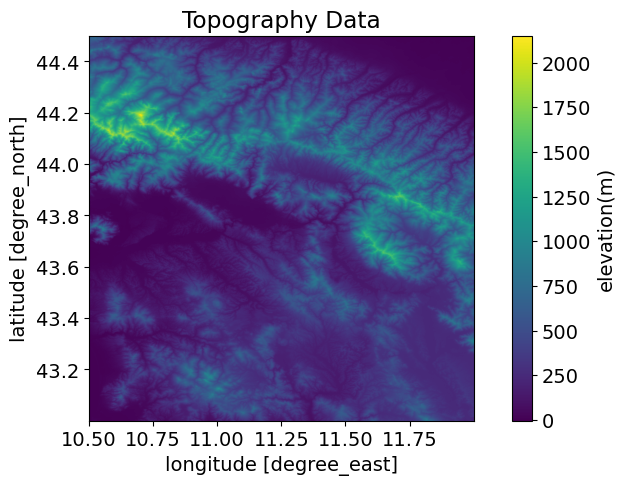

In [7]:
# get DEM variable data
dem_data = dem.get_value(var_name)
dem_data_2D = dem_data.reshape(dem_grid_shape)

# get X, Y extent for plot
min_y, min_x = dem_grid_origin
max_y = min_y + dem_grid_spacing[0]*(dem_grid_shape[0]-1)
max_x = min_x + dem_grid_spacing[1]*(dem_grid_shape[1]-1)
dy = dem_grid_spacing[0]/2
dx = dem_grid_spacing[1]/2
dem_extent = [min_x - dx, max_x + dx, min_y - dy, max_y + dy]

# plot DEM data
fig, ax = plt.subplots(1,1,figsize=(10,5))
im = ax.imshow(dem_data_2D, extent=dem_extent)
ax.title.set_text('Topography Data')
ax.set_xlabel('longitude [degree_east]')
ax.set_ylabel('latitude [degree_north]')
fig.colorbar(im,label='elevation(m)')

##### ERA5 
If the model is run in its complete form:
- volumetric soil water data will be used for calculating the susceptibility

- precipitation data will help visualize

The 'era5_config.yaml' file includes the parameter settings of this data component. 

Run the following cells to: 
- initialize ERA5
- see how to specify grid and time methods to get metadata and data values 



In [8]:
# initialize ERA5 data component
era5 = Era5()
era5.initialize(os.path.join(config_dir,'era5_config.yaml'))

In [9]:
# get ERA5 variable info
for var_name in era5.output_var_names:
    var_unit = era5.var_units(var_name)
    var_location = era5.var_location(var_name)
    var_type = era5.var_type(var_name)
    var_grid = era5.var_grid(var_name)
    var_itemsize = era5.var_itemsize(var_name)
    var_nbytes = era5.var_nbytes(var_name)
    # print('variable_name: {} \nvar_unit: {} \nvar_location: {} \nvar_type: {} \nvar_grid: {} \nvar_itemsize: {}' 
    #         '\nvar_nbytes: {} \n'. format(var_name, var_unit, var_location, var_type, var_grid, var_itemsize, var_nbytes))

In [10]:
# get ERA5 grid info
era5_grid_ndim = era5.grid_ndim(var_grid) 
era5_grid_type = era5.grid_type(var_grid)
era5_grid_shape = era5.grid_shape(var_grid)
era5_grid_spacing = era5.grid_spacing(var_grid)
era5_grid_origin = era5.grid_origin(var_grid)

# print('grid_ndim: {} \ngrid_type: {} \ngrid_shape: {} \ngrid_spacing: {} \ngrid_origin: {}'.format(
#     era5_grid_ndim, era5_grid_type, era5_grid_shape, era5_grid_spacing, era5_grid_origin))

In [11]:
# get ERA5 time info
era5_start_time = era5.start_time
era5_end_time = era5.end_time
era5_time_step = era5.time_step
era5_time_unit = era5.time_units
era5_time_steps = int((era5_end_time - era5_start_time)/era5_time_step) + 1

# print('start_time:{} \nend_time:{} \ntime_step:{} \ntime_unit:{} \ntime_steps:{}'.format(
#     era5_start_time, era5_end_time, era5_time_step, era5_time_unit, era5_time_steps))

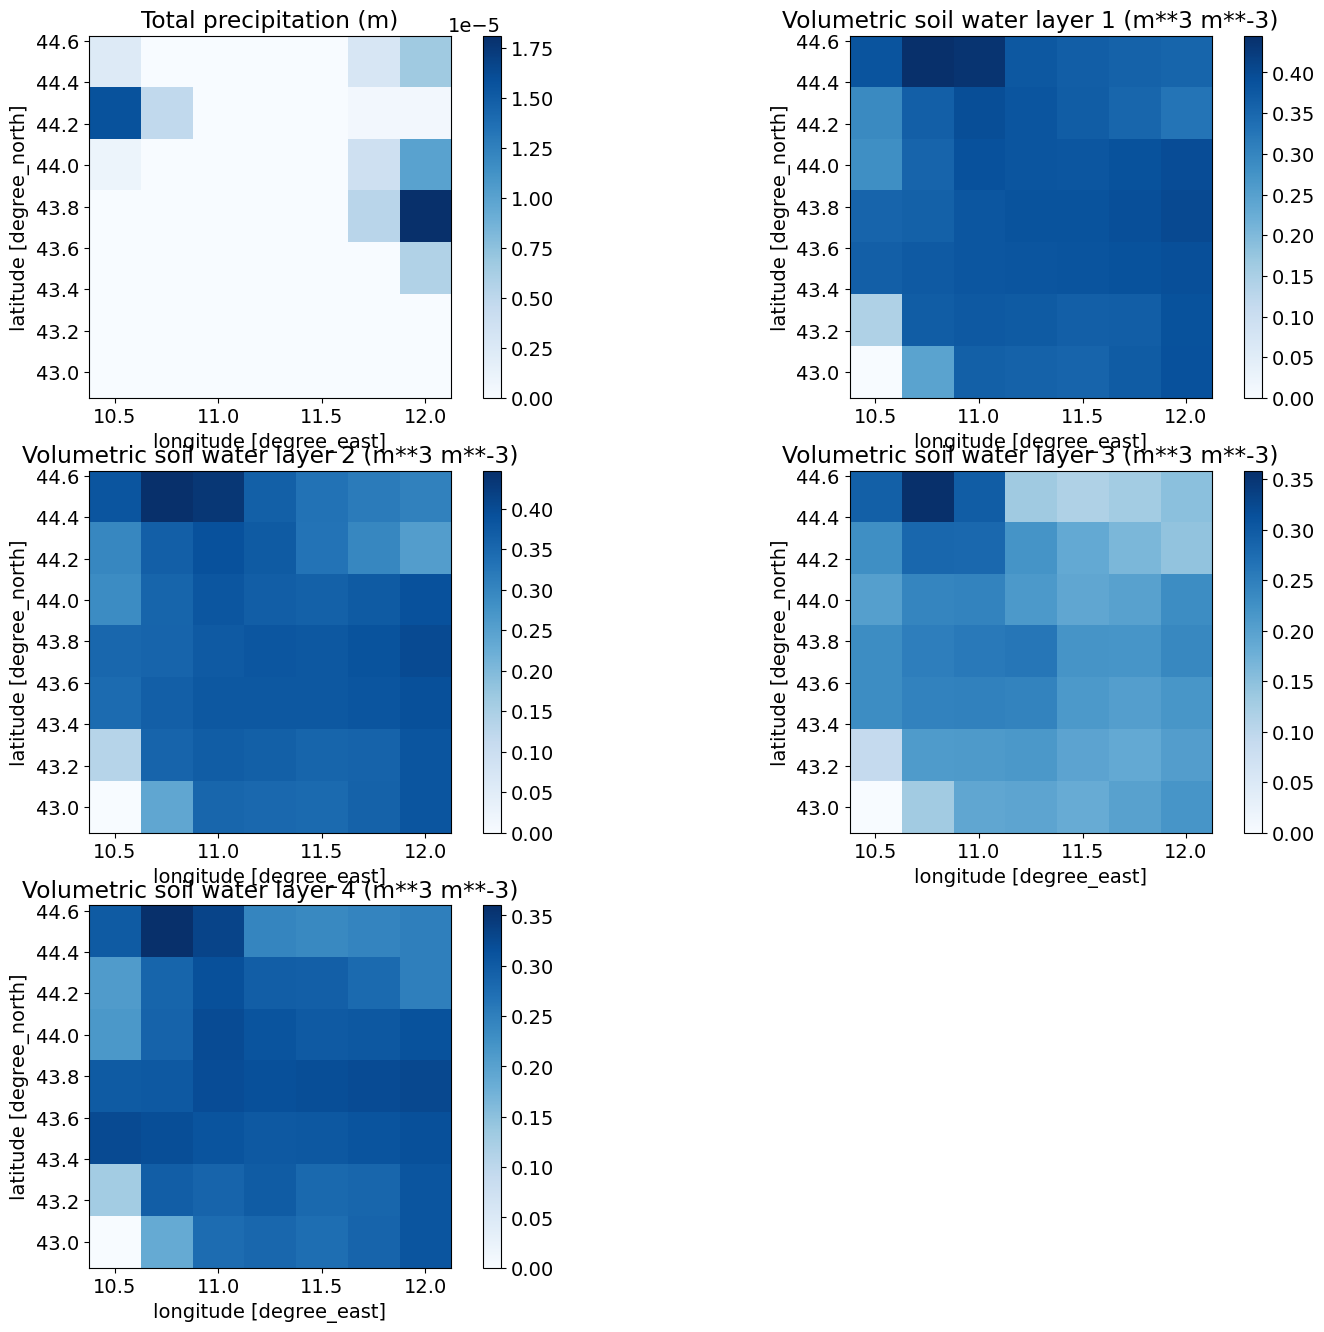

In [12]:
# get ERA5 variables data and plot (at the first time step)
fig = plt.figure(figsize=(18,16)) 
nrows, ncols = 3, 2
i = 1

for var_name in era5.output_var_names:
    ax = fig.add_subplot(nrows, ncols, i)
    var_unit = era5.var_units(var_name)
    
    # get variable data    
    era5_data = era5.get_value(var_name)
    era5_data_2D = era5_data.reshape(era5_grid_shape)
    
    # get X, Y extent for plot
    min_y, min_x = era5_grid_origin
    max_y = min_y + era5_grid_spacing[0]*(era5_grid_shape[0]-1)
    max_x = min_x + era5_grid_spacing[1]*(era5_grid_shape[1]-1)
    dy = era5_grid_spacing[0]/2
    dx = era5_grid_spacing[1]/2
    era5_extent = [min_x - dx, max_x + dx, min_y - dy, max_y + dy]

    # plot data
    im = ax.imshow(era5_data_2D, extent=era5_extent, cmap='Blues')
    ax.title.set_text('{} ({})'.format(var_name,var_unit ))
    ax.set_xlabel('longitude [degree_east]')
    ax.set_ylabel('latitude [degree_north]')
    cbar = plt.colorbar(im, ax=ax)
    
    i += 1

##### SoilGrids
Soil depth data with 250m resolution from [SoilGrids](https://www.isric.org/explore/soilgrids) system. In this dataset, the maximum soil depth value is 200cm. Grid with values larger than 200cm represents open water area. 

In [13]:
# download soil depth data
soil_raster = rioxarray.open_rasterio("https://files.isric.org/soilgrids/former/2017-03-10/data/BDRICM_M_250m_ll.tif")
soil_depth_data = soil_raster.rio.clip_box(
    minx=10.50,
    miny=43.50,
    maxx=11.25,
    maxy=44.25,
)

In [14]:
## plot soil depth data
# soil_depth_data.plot(figsize=(8,6),cbar_kwargs={'label': 'depth(m)'})
# soil_depth_data.rio.to_raster(os.path.join(cache_dir,'soil_depth.tif'))
# plt.title('Soil Depth')

##### Landlab RMG - Slope 
Topography data and the [RasterModelGrid](https://landlab.readthedocs.io/en/master/reference/grid/raster.html) from [Landlab](https://landlab.readthedocs.io/en/master/index.html) to calculate the slope angle

In [15]:
# calculate slope angle using Topography data
model_grid = RasterModelGrid(dem_data_2D.shape,xy_spacing=(90,90))
slope = model_grid.calc_slope_at_node(elevs=dem_data) # slope in radians, 1D array
slope_angle = slope.reshape(dem_data_2D.shape) # reshape as 2D array

In [16]:
# # plot slope angle
# fig, ax = plt.subplots(figsize=(10,5))
# im=ax.imshow(slope_angle, extent=dem_extent)
# cbar = fig.colorbar(im, label= 'radians')
# ax.title.set_text('Slope Angle')
# ax.set_xlabel('longitude [degree_east]')
# ax.set_ylabel('latitude [degree_north]')

#### Grid Setup

All datasets downloaded or calculated above are regrid in the same grid resolution. (again for specific details refer to [original notebook](https://github.com/gantian127/landslide_usecase/blob/master/landslide_puertorico.ipynb)

In [17]:
# define destination grid coordinate using Topography data
dem_y = np.flip(np.arange(dem_grid_shape[0])*dem_grid_spacing[0] + dem_grid_origin[0])
dem_x = np.arange(dem_grid_shape[1])*dem_grid_spacing[1] + dem_grid_origin[1]
dest_coor = {'lon': dem_x, 
             'lat': dem_y}

In [18]:
# regrid soil depth data
soil_depth_coor = {'lon': soil_depth_data.x.values,
                   'lat': soil_depth_data.y.values}

soil_depth = regrid_data(soil_depth_data.values[0], soil_depth_coor, dest_coor) 
soil_depth = soil_depth/100 # units conversion as m

In [19]:
# # plot regridded soil depth data
# fig, ax = plt.subplots(1,1,figsize=(10,5))
# im = ax.imshow(soil_depth, extent=dem_extent)
# ax.title.set_text('Regridded Soil Depth Data')
# ax.set_xlabel('longitude [degree_east]')
# ax.set_ylabel('latitude [degree_north]')
# cbar = plt.colorbar(im, label='depth(m)')

## Landscape Susceptibility

**Factor of safety**

In geological engineering, it is common to take the ratio of the resisting stresses to driving stresses. This ratio is called the factor of safety (FS). When FS is larger than 1, the slope should be stable, while if it is below 1, the driving stress exceeds the resistance and the slope is likely to fail. FS can be calculated with the following function, and cal_safety_factor( ) is implemented based on this function.

$$
FS = \frac{(C_r + C_s)/h_s\rho_sg}{\sin\theta} + \frac{\cos\theta \tan\phi (1-\frac{h_w}{h_s}\rho_w / \rho_s)}{\sin\theta}
$$

where, 
- Cr: root cohesion (Pa kg/ms^2)
- Cs: soil cohesion (Pa kg/ms^2)
- hs: soil depth (m)
- hw: subsurface flow depth (m)
- ρs: soil density (kg/m^3)
- ρw: water density (kg/m^3)
- g: gravity acceleration (m/s^2)
- θ: slope angle 
- φ: soil internal friction angle 

**Susceptibility**

Susceptibility is the inverse of FS. When the susceptibility is larger than 1, it means that the slope of the area is not stable and susceptible to landslide.  

$$
\text{Susceptibility} = \frac{1}{FS}
$$


**Plot Results**

There are four subplots created for a list of different susceptibility values. 

In [20]:
# Specify minimum and maximum root cohesion parameters for the area
min_Cr=3000
max_Cr=12000

# Do a list with 4 equally spaced values within that range 
step_Cr=int(((max_Cr+min_Cr)-min_Cr)/4)
root_c=[i for i in range(min_Cr,max_Cr+1,step_Cr)] #list of values for root cohesion repoorted for area

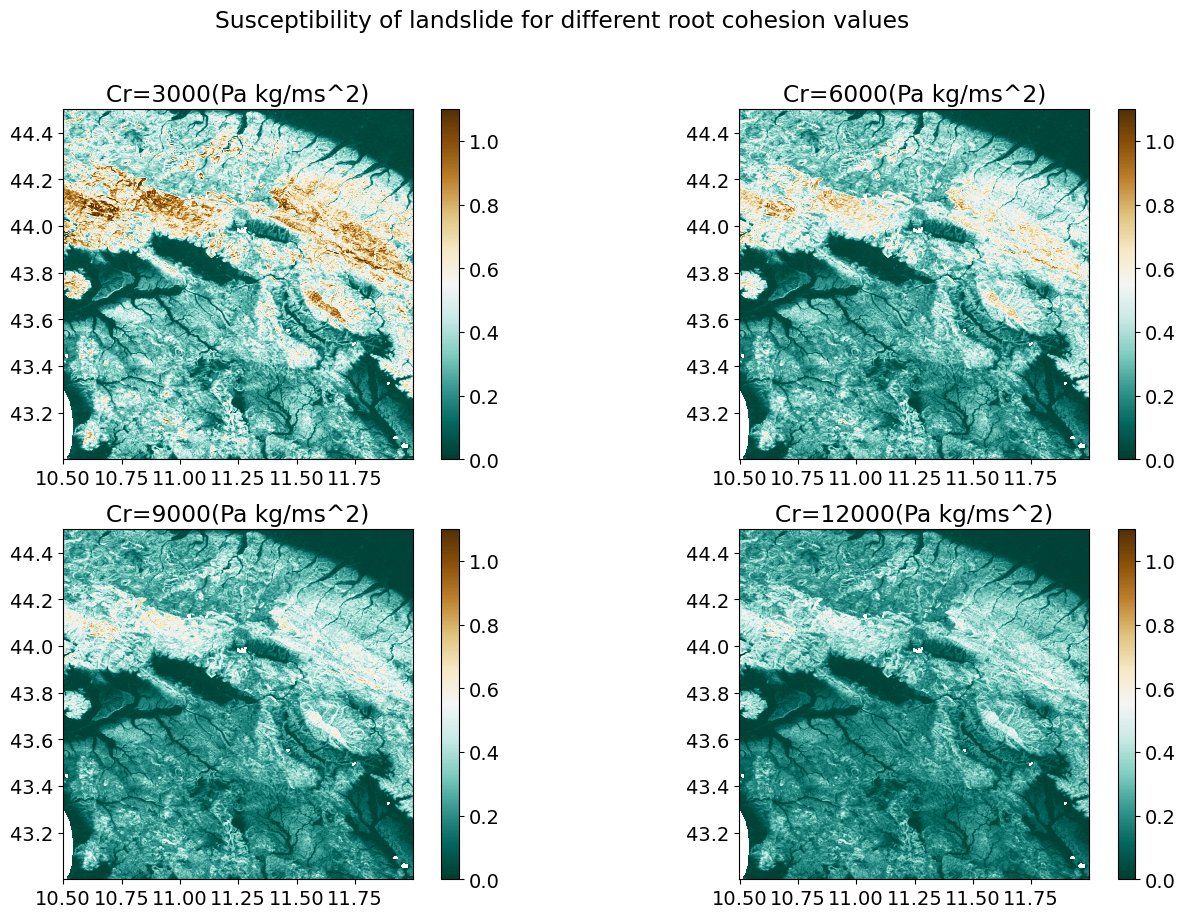

In [31]:
# define mask for non-data area (water bodies, etc)
mask = (slope_angle==0)&(soil_depth>2.0)

# we assume constant saturation so that relative wetness is one
subsurface_flow_depth = soil_depth 

# plot susceptibility 
fig = plt.figure(figsize=(16,10))
fig.suptitle("Susceptibility of landslide for different root cohesion values")

#change plot grid size if you want to explore more parameters in the above list
nrows, ncols = 2,2
    
# calculate FS for each root cohesion value
for i,cr in enumerate(root_c):
    safety_factor = cal_safety_factor(slope_angle, subsurface_flow_depth, soil_depth, 
                                  root_cohesion=cr, soil_cohesion=5000, soil_bulk_density=1300,
                                  soil_internal_friction_angle=35)
    
    # calculate susceptibility
    susceptibility = 1.0 / safety_factor
    susceptibility = np.where(~mask, susceptibility, np.nan) #water bodies
    
    # plot 
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.title.set_text('Cr='+str(cr)+"(Pa kg/ms^2)")
    im_data = susceptibility
    
###### Comment the 2 above lines and uncomment below to check the differences""   
#     if cr == 5000: 
#         ax = fig.add_subplot(nrows, ncols, 1)
#         im_data = susceptibility
#         reference_sus = np.copy(susceptibility) 
        
#     else: 
#         ax = fig.add_subplot(nrows, ncols, i+1)
#         im_data = susceptibility - reference_sus

    im_sus = ax.imshow(im_data, cmap='BrBG_r', extent=dem_extent)
    plt.colorbar(im_sus, ax=ax)
    im_sus.set_clim(0,1.1)
    

#save plot 
fig.savefig(results_dir+'/root_cohesion_plot.png')



<large>**What differences can you notice in the landscape?**
    
Remember that a susceptibility close to 1 means the landscape is prone to landslides and when it's close to zero it is stable.

## References
- Strauch, R., Istanbulluoglu, E., Nudurupati, S. S., Bandaragoda, C., Gasparini, N. M., and Tucker, G. E. (2018), A hydroclimatological approach to predicting regional landslide probability using Landlab, Earth Surf. Dynam., 6, 49–75, https://doi.org/10.5194/esurf-6-49-2018
- Montgomery, D. R., and Dietrich, W. E. (1994), A physically based model for the topographic control on shallow landsliding, Water Resour. Res., 30( 4), 1153– 1171, https://doi.org/10.1029/93WR02979.